<a href="https://colab.research.google.com/github/yeejingzuTUAT/Image-features-of-a-splashing-drop-on-a-solid-surface-extracted-using-a-feedforward-neural-network/blob/main/JN_GitHub_ImageAndImageSequenceClassificationForSplashingAndNonsplashingDrops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Publications:

1. Jingzu Yee, Daichi Igarashi (五十嵐大地), Akinori Yamanaka (山中晃徳), and Yoshiyuki Tagawa (田川義之) , "Video-Based Classification of Splashing and Nonsplashing Drops using an Interpretable Artificial Neural Network", *submitted to AIAA Journal*, (2022)

2. Jingzu Yee, Daichi Igarashi, Akinori Yamanaka and Yoshiyuki Tagawa. "Features of a Splashing Drop on a Solid Surface and the Temporal Evolution extracted through Image-Sequence Classification using an Interpretable Feedforward Neural Network," AIAA 2022-4174. AIAA AVIATION 2022 Forum. June 2022. https://doi.org/10.2514/6.2022-4174

3. Jingzu Yee, Akinori Yamanaka (山中晃徳), and Yoshiyuki Tagawa (田川義之) , "Image features of a splashing drop on a solid surface extracted using a feedforward neural network", Physics of Fluids 34, 013317 (2022) https://doi.org/10.1063/5.0077050

# 1) Setup

In [ ]:
#Importing libraries
import os

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical

from scipy.stats import pearsonr
from scipy.stats import spearmanr

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

import matplotlib
import matplotlib.pyplot as plt

import cv2
import glob
import math
import numpy as np
import pandas as pd
import shutil

from tqdm import tqdm
from zipfile import ZipFile

# 2) Choosing Image Types
(Unhide to enter password and choose the type of images: r$\tau(=1-z_0/D_0)$ and the focus of the image)

In [ ]:
#Font designs for figures
from matplotlib.font_manager import FontProperties

fs = 16
font = FontProperties()
font.set_size(fs)
font_leg = FontProperties()
font_leg.set_family('Serif')
font_leg.set_size(12)

In [ ]:
#1. For image-sequence classification: 1, for image classification: 0)
combine = 0

#2. For image classification, set the value of tau(=1-z0/D0) (0.125, 0.250, 0.375, 0.500, 0.625, 0.75 or 0.875)
tau = 0.250

# 3) Load Data

In [ ]:
#Data is available upon request
path_imageData = f'//xxx/'
path_drop = path_imageData + f'Data_2022_0909/'
path_ans = path_imageData + f'answer.csv'

In [ ]:
#Load id & label
M_answer = pd.read_csv(path_ans)
M_id = M_answer['id'].values
M_H = M_answer['H'].values
M_U = M_answer['U'].values
M_Re = M_answer['Re'].values
M_We = M_answer['We'].values
M_label = M_answer['Label'].values

In [ ]:
#Load images
data_image = []
view_data_image = []
for i in tqdm(range(M_id.shape[0])):
    image2 = cv2.imread(path_drop+'drop02/'+M_id[i].astype('str')+'.tif',0)
    image3 = cv2.imread(path_drop+'drop03/'+M_id[i].astype('str')+'.tif',0)
    image4 = cv2.imread(path_drop+'drop04/'+M_id[i].astype('str')+'.tif',0)
    image5 = cv2.imread(path_drop+'drop05/'+M_id[i].astype('str')+'.tif',0)
    image6 = cv2.imread(path_drop+'drop06/'+M_id[i].astype('str')+'.tif',0)
    image7 = cv2.imread(path_drop+'drop07/'+M_id[i].astype('str')+'.tif',0)
    image8 = cv2.imread(path_drop+'drop08/'+M_id[i].astype('str')+'.tif',0)
    
    if combine == 0:
        img_str = 'image'+str(round(tau/0.125))
        image = np.array([globals()[img_str]])
        image = image.reshape(image8.shape[0]*image8.shape[1]) 
    elif combine == 1:
        image = np.array([image2,image3,image4,image5,image6,image7,image8])
        image = image.reshape((image8.shape[0]*image8.shape[1]*7))
    else:
        del image
        
    image = image/255
    data_image.append(image)

img_h = image8.shape[0]
img_w = image8.shape[1]
img_pix = img_h * img_w
M_imgs = np.array(data_image)

100%|██████████| 260/260 [00:12<00:00, 20.91it/s]


In [ ]:
#Combining all the data into a masterlist
M_all = []
for i in range(M_We.shape[0]):
    M_all_append = [M_id[i],M_H[i],M_label[i],M_imgs[i],M_We[i],M_Re[i],M_U[i]]
    M_all.append(M_all_append)

# 4) Preparation for Fivefold Cross Validation

In [ ]:
train_pc = 0.8
interval = 'no'
interval_h = 8

#For extrapolation, interpolate must be = 'no'
extrapolate_high = 'no'
exhigh = 44
extrapolate_low = 'no'
exlow = 8

#For interpolation, extrapolate_high and extrapolate_low must be = 'no'
interpolate = 'no'
inhigh = 30
inlow = 20

remove_outliers = 'yes'
first_frame = 'yes'

In [ ]:
#Remove outliers
#Variables: otl, H, id, label, imgs
if remove_outliers == 'yes':
    if first_frame == 'yes':
        otl = [39,42,72,99,138,182,206,223,232,258,260]
    else:
        #id of images not in resolution range
        otl = [39,72,182,206,223,232,258,260]
        
    i = 0
    while i < len(M_all):
        if np.sum(M_all[i][0] == otl) == 1:
            #print(M_all[i][0])
            M_all.remove(M_all[i])
            i = i - 1
        i += 1

In [ ]:
#defining a function for train_ans for comb_k
#variables: train_ans, label, id
#loop: i,j,k,k1,k2,kk
def comb(k):
    k1 = 2 * k
    tp = int(((1 - train_pc) * 10 ) - 2)
    k_all = list(range(k1-1,k1 + tp + 1))
    k_all = [el%10 for el in k_all]
  
    train_out = []
    test_out = []
  
    for i in range(len(M_all)):
        kk = M_all[i][0]%10
        kk2 = M_all[i][1]%interval_h
        if extrapolate_high == 'yes' or extrapolate_low == 'yes':
            if interpolate == 'yes':
                break
    
        if interval == 'yes' and kk2 != 0:
            test_out.append(M_all[i])
        elif extrapolate_high == 'yes' and M_all[i][1] >= exhigh:
            test_out.append(M_all[i])
        elif extrapolate_low == 'yes' and M_all[i][1] <= exlow:
            test_out.append(M_all[i])
        elif interpolate == 'yes' and M_all[i][1] >= inlow and M_all[i][1] <= inhigh:
            test_out.append(M_all[i])
        elif np.sum(kk == k_all) == 1:
            test_out.append(M_all[i])
        else:
            train_out.append(M_all[i])
  
    return train_out, test_out

In [ ]:
#Preparing data for each combination
id_train = []
id_test = []
H_train = []
H_test = []
y_train = []
y_test = []
x_train = []
x_test = []
We_train = []
We_test = []
Re_train = []
Re_test = []
U_train = []
U_test = []


for i in range(1,6):
    id_train.append(np.array([el[0] for el in comb(i)[0]]))
    id_test.append(np.array([el[0] for el in comb(i)[1]]))
    H_train.append(np.array([el[1] for el in comb(i)[0]]))
    H_test.append(np.array([el[1] for el in comb(i)[1]]))
    y_train.append(to_categorical([el[2] for el in comb(i)[0]]))
    y_test.append(to_categorical([el[2] for el in comb(i)[1]]))
    x_train.append(np.array([el[3] for el in comb(i)[0]]))
    x_test.append(np.array([el[3] for el in comb(i)[1]]))
    We_train.append(np.array([el[4] for el in comb(i)[0]]))
    We_test.append(np.array([el[4] for el in comb(i)[1]]))
    Re_train.append(np.array([el[5] for el in comb(i)[0]]))
    Re_test.append(np.array([el[5] for el in comb(i)[1]]))
    U_train.append(np.array([el[6] for el in comb(i)[0]]))
    U_test.append(np.array([el[6] for el in comb(i)[1]]))

# 5) Check Prepared Data

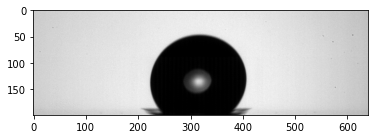

ID : 255
Label : 1


In [ ]:
i = np.random.choice(len(x_train))
j = np.random.choice(len(x_train[i]))
 
view_img = x_train[i][j].reshape(x_train[i][j].shape[0])
view_img = view_img.reshape(round(x_train[i][j].shape[0]/img_w),img_w)

plt.imshow(view_img.squeeze(), cmap=plt.cm.gray)
plt.show()
print('ID : ' + str(id_train[i][j]))
print('Label : ' + str(int(y_train[i][j][1])))

In [ ]:
#Check the Number of Data
# date = 'result_2022_0330_extrapolation_12to38'
# path_result = '/content/drive/Othercomputers/My MacBook Pro/Backup/'+\
# 'Analysis_Backup on/'+ date +'/'
path_result = 'result/'
if os.path.exists(path_result) == 1:
    shutil.rmtree(path_result)
os.mkdir(path_result)

path_data_num = path_result + 'DataNum/'
os.mkdir(path_data_num)

for comb in range(1,6):
    k = comb - 1
    
    count_df = pd.DataFrame(columns=['Type','Spl.','Nonspl.', 'Tot.'])
    count1 = np.count_nonzero(y_train[k][:,1] == 1)
    count111 = H_train[k].shape[0]
    count11 = count111 - count1
    
    count2 = np.count_nonzero(y_test[k][:,1] == 1)
    count222 = H_test[k].shape[0]
    count22 = count222 - count2
    
    count_df.loc[0] = ['Train', count1, count11, count111]
    count_df.loc[1] = ['Test',count2, count22, count222]
    count_df.loc[2] = ['Tot.', count1+count2, count11+count22, 
                       count111+count222]
    
    count_name = path_data_num+'DataNum_comb'+str(comb)+'.csv'
    count_df.to_csv(count_name, header=True, index=False)
    
    print('Comb. ',comb,':')
    print(count_df)
    print('\n')

Comb.  1 :
    Type Spl. Nonspl. Tot.
0  Train  114      87  201
1   Test   27      21   48
2   Tot.  141     108  249


Comb.  2 :
    Type Spl. Nonspl. Tot.
0  Train  112      86  198
1   Test   29      22   51
2   Tot.  141     108  249


Comb.  3 :
    Type Spl. Nonspl. Tot.
0  Train  113      85  198
1   Test   28      23   51
2   Tot.  141     108  249


Comb.  4 :
    Type Spl. Nonspl. Tot.
0  Train  114      85  199
1   Test   27      23   50
2   Tot.  141     108  249


Comb.  5 :
    Type Spl. Nonspl. Tot.
0  Train  111      89  200
1   Test   30      19   49
2   Tot.  141     108  249




# 6) Feedforward Neural Network and Hyperparameter Tuning

In [ ]:
#Defining the Model Structure
model = Sequential()
model.add(Dense(2, activation = 'sigmoid', input_shape = (x_train[0][0].shape[0],)))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 256002    
Total params: 256,002
Trainable params: 256,002
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Hyperparameter tuning
epoch = 10000
batch = 32
split = 0.2
LR = 0.00015
Mmntm = 0.9
ptnc = 25
#(Recommended: batch = 32, LR = 5e-5 to 5e-4 , Mmntm = 0.9)

#Define the callback list & sgd
callback = [keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0,
    patience=ptnc, restore_best_weights=True)]

opt = optimizers.SGD(learning_rate = LR, momentum = Mmntm)

In [ ]:
#Compiling the model
path_model = path_result + 'models/'
if os.path.exists(path_model) == 0:
    os.mkdir(path_model)

if os.path.exists(path_model+'model_ini.h5py') == 1:
    print(path_model+'model_ini.h5py')
    model = load_model(path_model+'model_ini.h5py')
else:
    print("Doesn't exist")

model.compile(optimizer=opt,loss ='binary_crossentropy', metrics=['acc'])
model.save(path_model+'model_ini.h5py')

Doesn't exist
INFO:tensorflow:Assets written to: result/models/model_ini.h5py\assets


In [ ]:
#Initial weights & biases
w_ini = model.layers[0].get_weights()[0]
b_ini = model.layers[0].get_weights()[1]

# 7) Training for All Combinations

(Skip this step if trained models are available for visualization)

In [ ]:
#Training the model for comb1
model1 = load_model(path_model+'model_ini.h5py')
history1 = model1.fit(x_train[0], y_train[0], batch_size = batch,
                      epochs = epoch, verbose = 2, validation_split = split,
                      callbacks = callback)
model1.save(path_model+'model_comb1.h5py')

Epoch 1/10000
5/5 - 0s - loss: 0.7220 - acc: 0.4938 - val_loss: 1.0018 - val_acc: 0.0000e+00
Epoch 2/10000
5/5 - 0s - loss: 0.6898 - acc: 0.6313 - val_loss: 0.8259 - val_acc: 0.0000e+00
Epoch 3/10000
5/5 - 0s - loss: 0.6819 - acc: 0.5000 - val_loss: 0.8448 - val_acc: 0.0000e+00
Epoch 4/10000
5/5 - 0s - loss: 0.6709 - acc: 0.5000 - val_loss: 0.8898 - val_acc: 0.0244
Epoch 5/10000
5/5 - 0s - loss: 0.7518 - acc: 0.4938 - val_loss: 0.3045 - val_acc: 1.0000
Epoch 6/10000
5/5 - 0s - loss: 0.6694 - acc: 0.5938 - val_loss: 0.2047 - val_acc: 1.0000
Epoch 7/10000
5/5 - 0s - loss: 0.6333 - acc: 0.6000 - val_loss: 0.4295 - val_acc: 0.9512
Epoch 8/10000
5/5 - 0s - loss: 0.5420 - acc: 0.7937 - val_loss: 0.5453 - val_acc: 0.8780
Epoch 9/10000
5/5 - 0s - loss: 0.5509 - acc: 0.7688 - val_loss: 0.5958 - val_acc: 0.7805
Epoch 10/10000
5/5 - 0s - loss: 0.5081 - acc: 0.8188 - val_loss: 0.5424 - val_acc: 0.8537
Epoch 11/10000
5/5 - 0s - loss: 0.5110 - acc: 0.7563 - val_loss: 0.5792 - val_acc: 0.8049
Epoch 1

Epoch 92/10000
5/5 - 0s - loss: 0.3130 - acc: 0.8625 - val_loss: 0.1073 - val_acc: 0.9756
Epoch 93/10000
5/5 - 0s - loss: 0.3272 - acc: 0.8625 - val_loss: 0.1740 - val_acc: 0.9512
Epoch 94/10000
5/5 - 0s - loss: 0.3157 - acc: 0.8687 - val_loss: 0.2069 - val_acc: 0.9268
Epoch 95/10000
5/5 - 0s - loss: 0.3248 - acc: 0.8625 - val_loss: 0.1649 - val_acc: 0.9512
Epoch 96/10000
5/5 - 0s - loss: 0.3221 - acc: 0.8500 - val_loss: 0.1020 - val_acc: 0.9756
Epoch 97/10000
5/5 - 0s - loss: 0.3135 - acc: 0.8625 - val_loss: 0.2222 - val_acc: 0.9268
Epoch 98/10000
5/5 - 0s - loss: 0.3072 - acc: 0.8750 - val_loss: 0.1263 - val_acc: 0.9512
Epoch 99/10000
5/5 - 0s - loss: 0.3195 - acc: 0.8750 - val_loss: 0.1666 - val_acc: 0.9512
Epoch 100/10000
5/5 - 0s - loss: 0.3406 - acc: 0.8625 - val_loss: 0.2314 - val_acc: 0.9268
Epoch 101/10000
5/5 - 0s - loss: 0.3155 - acc: 0.8687 - val_loss: 0.1512 - val_acc: 0.9512
Epoch 102/10000
5/5 - 0s - loss: 0.3059 - acc: 0.8687 - val_loss: 0.2389 - val_acc: 0.9268
Epoch 1

In [ ]:
#Training the model for comb2
model2 = load_model(path_model+'model_ini.h5py')
history2 = model2.fit(x_train[1], y_train[1], batch_size = batch,
                      epochs = epoch, verbose = 0, validation_split = split,
                      callbacks = callback)
model2.save(path_model+'model_comb2.h5py')

INFO:tensorflow:Assets written to: result/models/model_comb2.h5py\assets


In [ ]:
#Training the model for comb3
model3 = load_model(path_model+'model_ini.h5py')
history3 = model3.fit(x_train[2], y_train[2], batch_size = batch,
                      epochs = epoch, verbose = 0, validation_split = split,
                      callbacks = callback)
model3.save(path_model+'model_comb3.h5py')

INFO:tensorflow:Assets written to: result/models/model_comb3.h5py\assets


In [ ]:
#Training the model for comb4
model4 = load_model(path_model+'model_ini.h5py')
history4 = model4.fit(x_train[3], y_train[3], batch_size = batch,
                      epochs = epoch, verbose = 0, validation_split = split,
                      callbacks = callback)
model4.save(path_model+'model_comb4.h5py')

INFO:tensorflow:Assets written to: result/models/model_comb4.h5py\assets


In [ ]:
#Training the model for comb5
model5 = load_model(path_model+'model_ini.h5py')
history5 = model5.fit(x_train[4], y_train[4], batch_size = batch,
                      epochs = epoch, verbose = 0, validation_split = split,
                      callbacks = callback)
model5.save(path_model+'model_comb5.h5py')

INFO:tensorflow:Assets written to: result/models/model_comb5.h5py\assets


# 8) Load/Save Trained Models

In [ ]:
model1 = load_model(path_model+'model_comb1.h5py')
model2 = load_model(path_model+'model_comb2.h5py')
model3 = load_model(path_model+'model_comb3.h5py')
model4 = load_model(path_model+'model_comb4.h5py')
model5 = load_model(path_model+'model_comb5.h5py')

In [ ]:
#compiling all trained models in model_all
model_all = []
model_all.append(model1)
model_all.append(model2)
model_all.append(model3)
model_all.append(model4)
model_all.append(model5)

# 9) Loss & Accuracy

## 9.1) Define plot functions

In [ ]:
#save training history
path_log = path_result + 'train_log/'
if os.path.exists(path_log) == 0:
    os.mkdir(path_log)

if 'history1' in globals():
    for i in range(1,6):
        k = globals()['history'+str(i)]
        log = pd.DataFrame(k.history)
        log_name = path_log+'log_comb'+str(i)+'.csv'
        log.to_csv(log_name, header=True, index=False)

In [ ]:
#Plotting loss & accuracy for one combination
def plot_loss_acc(comb):
    log_name = path_log+'log_comb'+str(i)+'.csv'
    k = pd.read_csv(log_name)
    
    train_loss = k['loss']
    val_loss = k['val_loss']
    train_acc = k['acc']
    val_acc = k['val_acc']
    
    epoch_plt = list(range(1, len(val_loss) + 1))
    
    fig = plt.figure()
    
    ax1 = fig.add_subplot(111)
    lns1 = ax1.plot(epoch_plt, train_loss, '-r', 
                    label = 'traning loss')
    lns2 = ax1.plot(epoch_plt, val_loss,
                    label = 'validation loss', c='tab:orange')
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    
    ax2 = ax1.twinx()
    lns3 = ax2.plot(epoch_plt, train_acc, '-b',
                    label = 'training accuracy')
    lns4 = ax2.plot(epoch_plt, val_acc, '-g',
                    label = 'validation accuracy')
    plt.yticks(fontsize=fs)
    
    lns = lns1+lns2+lns3+lns4
    labs = [l.get_label() for l in lns]
    leg = ax1.legend(lns, labs, loc=5, prop=font_leg)
    
    ax1.set_xlabel('Epoch', fontproperties=font)
    ax1.set_ylabel('Loss', fontproperties=font)
    ax2.set_ylabel('Accuracy', fontproperties=font, rotation=-90, labelpad=15)
    #ax1.set_ylim(-0.05,1.05)
    ax2.set_ylim(-0.05,1.05)
    
    title_loss_acc = 'Combination ' + str(comb)
    plt.title(title_loss_acc, fontproperties=font)
    plt.grid(linestyle='solid', alpha=0.5)

In [ ]:
#Plotting loss
def plot_loss(comb):
    
    log_name = path_log+'log_comb'+str(comb)+'.csv'
    k = pd.read_csv(log_name)
    
    train_loss = k['loss']
    val_loss = k['val_loss']
    
    label_train_loss = 'Comb. ' + str(comb) + ' (train.)'
    label_val_loss = 'Comb. ' + str(comb) + ' (val.)'
    
    epoch_plt = list(range(1, len(val_loss) + 1))
    
    #Taking only every 50th step
    epoch_plt = np.array(epoch_plt)
    train_loss = np.array(train_loss)
    val_loss = np.array(val_loss)
    epoch_plt = epoch_plt[::50]
    train_loss = train_loss[::50]
    val_loss = val_loss[::50]
    
    sameColor = next(colorIter)

    plt.plot(epoch_plt, train_loss, 'o--', c = sameColor,# mfc = 'None',
             label = label_train_loss)
    plt.plot(epoch_plt, val_loss, '^:', c = sameColor,# mfc = 'None', 
             label = label_val_loss)
    #plt.ylim(-0.05,1.05)
    
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlabel('Epoch [-]', fontproperties=font)
    plt.ylabel('Loss [-]', fontproperties=font)
    plt.grid(linestyle='solid', alpha=0.5)
    leg = plt.legend(loc=0, prop=font_leg, ncol=2, frameon=True)
    leg.get_frame().set_edgecolor('black')

In [ ]:
#Plotting accuracy
def plot_acc(comb):
    
    log_name = path_log+'log_comb'+str(comb)+'.csv'
    k = pd.read_csv(log_name)
    
    train_acc = k['acc']
    val_acc = k['val_acc']
    
    label_train_acc = 'Comb. ' + str(comb) + ' (train.)'
    label_val_acc = 'Comb. ' + str(comb) + ' (val.)'
    
    epoch_plt = list(range(1, len(val_acc) + 1))

    #Taking only every 50th step
    epoch_plt = np.array(epoch_plt)
    train_acc = np.array(train_acc)
    val_acc = np.array(val_acc)
    epoch_plt = epoch_plt[::50]
    train_acc = train_acc[::50]
    val_acc = val_acc[::50]

    sameColor = next(colorIter)

    plt.plot(epoch_plt, train_acc, 'o--', c = sameColor,# mfc = 'None',
             label = label_train_acc)
    plt.plot(epoch_plt, val_acc, '^:', c = sameColor,# mfc = 'None', 
             label = label_val_acc)
    # plt.xlim(-10,max(epoch_plt)+10)
    plt.ylim(-0.05,1.05)
    
    # plt.xticks(np.arange(0,2001, step = 500),fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlabel('Epoch [-]', fontproperties=font)
    plt.ylabel('Accuracy [-]', fontproperties=font)
    # plt.title('Accuracy vs. Epoch', fontproperties=font)
    plt.grid(linestyle='solid', alpha=0.5)
    leg = plt.legend(loc=0, prop=font_leg, ncol=2, frameon=True)
    leg.get_frame().set_edgecolor('black')

## 9.2) Plots

In [ ]:
path_LossAcc = path_result + 'LossAcc/'
if os.path.exists(path_LossAcc) == 0:
    os.mkdir(path_LossAcc)

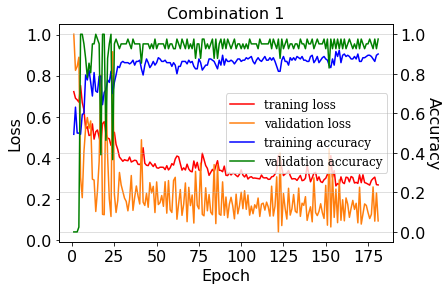

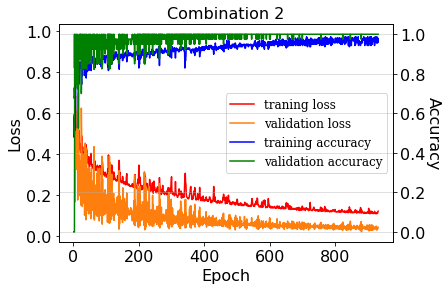

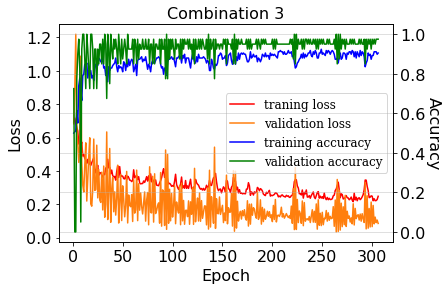

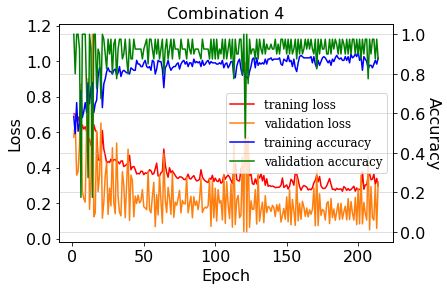

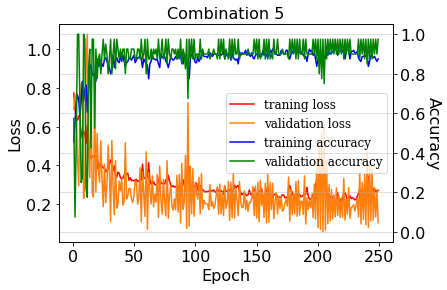

In [ ]:
for i in range(1,6):
    plot_loss_acc(i)
    plt.savefig(path_LossAcc+'LossAcc_Comb%d.png'%i, dpi=300, bbox_inches='tight')
    plt.show()

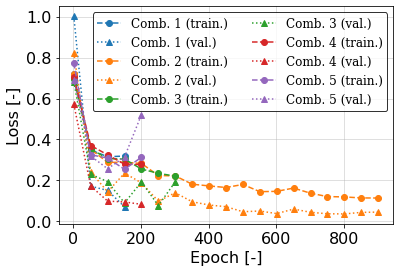

In [ ]:
colorIter = iter(
    ('tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'))

for i in range(1,6):
    plot_loss(i)
    plt.savefig(path_LossAcc+'CombAll_Loss.png', dpi=300, bbox_inches='tight')

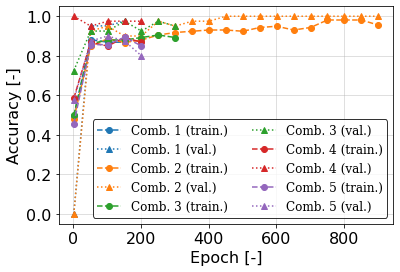

In [ ]:
#colorIter has to be redefined after plotting 'CombAll_Loss.png'
colorIter = iter(
    ('tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'))

for i in range(1,6):
    plot_acc(i)
    plt.savefig(path_LossAcc+'CombAll_Acc.png', dpi=300, bbox_inches='tight')

# 10) Testing

## 10.1) Define functions

In [ ]:
path_test = path_result + 'test/'

if os.path.exists(path_test) == 0:
  os.mkdir(path_test)

In [ ]:
#Compiling the probability & prediction of all combinations
prob = []
pred = []

for i in range(1,6):
    i = i - 1
    prob.append(model_all[i].predict(x_test[i]))
    pred.append(np.argmax(model_all[i].predict(x_test[i]), axis=-1))

In [ ]:
#Define function for test result of comb_k
def result_test(comb):
    k = comb - 1
    
    #Checking the prediction with answer
    TF = []
    for i in range(pred[k].shape[0]):
        if pred[k][i] == y_test[k][i,1]:
            tfpn = 'T'
        else:
            tfpn = 'F'
        
        if pred[k][i] == 1:
            tfpn = tfpn + 'P'
        else:
            tfpn = tfpn + 'N'
        TF.append(tfpn)
    
    TF = np.array(TF)
  
    #Saving test result on a df
    result_test = pd.DataFrame(H_test[k][:], columns = ['H'])
    result_test['id'] = id_test[k][:]
    result_test['prob.'] = np.round(prob[k][:,1],2)
    result_test['pred.'] = pred[k]
    result_test['ans.'] = y_test[k][:,1].astype(int)
    result_test['T/F'] = TF

    result_test_name = path_test+'test_comb'+str(comb)+'.csv'
    result_test.to_csv(result_test_name, header=True, index=False)
  
    #Counting correct/wrong prediction
    TP = np.count_nonzero(TF == 'TP')
    TN = np.count_nonzero(TF == 'TN')
    Total_P = np.count_nonzero(y_test[k][:,1] == 1)
    Total_N = np.count_nonzero(y_test[k][:,1] == 0)
    Correct = TP + TN
    TP_pc = int(TP/Total_P*100)
    TN_pc = int(TN/Total_N*100)
    Correct_pc = int(Correct/TF.shape[0]*100)
    TP_frac = str(TP)+'/'+str(Total_P)
    TN_frac = str(TN)+'/'+str(Total_N)
    Correct_frac = str(Correct)+'/'+str(TF.shape[0])
    
    TPTN.append([comb, TP_frac, TP_pc, TN_frac, TN_pc, Correct_frac,Correct_pc])
    
    return result_test

In [ ]:
#Test result for all combinations
result_test_all = []
TPTN = []

for i in range(1,6):
    result_test_all.append(result_test(i))

## 10.2) Test Results

In [ ]:
TPTN_df = pd.DataFrame(columns=['Comb','Spl.', 'Spl. (%)', 'Nonspl.', 
                                'Nonspl. (%)', 'Tot.','Tot. (%)'])

for i in range(len(TPTN)):
    TPTN_df.loc[i] = TPTN[i]

TPTN_df.to_csv(path_test+'test_combAll.csv', header=True, index=False)
TPTN_df

,Comb,Spl.,Spl. (%),Nonspl.,Nonspl. (%),Tot.,Tot. (%)
0,1,21/27,77,21/21,100,42/48,87
1,2,24/29,82,21/22,95,45/51,88
2,3,21/28,75,23/23,100,44/51,86
3,4,27/27,100,20/23,86,47/50,94
4,5,26/30,86,16/19,84,42/49,85


# 11) Visualization


## 11.1) Extraction and Calculation

In [ ]:
#Extracting the weights & biases for all combinations
w_train = []
b_train = []

for i in range(5):
    w_train.append(
        model_all[i].layers[0].get_weights()[0])
    b_train.append(
        model_all[i].layers[0].get_weights()[1])

In [ ]:
#Calculating W1s, q, q1, q2 for all combinations
Ws = []
q_out = []
y_pred = []

for i in range(5):
    Ws.append(np.dot(x_test[i],w_train[i]))
    q_out.append(Ws[i] + b_train[i])
    y_pred.append(1/(1+np.exp(-q_out[i])))

## 11.2) Weight $\mathbf{W}$

### 11.2.1) Initial weight

In [ ]:
w_ini.shape

(128000, 2)

0


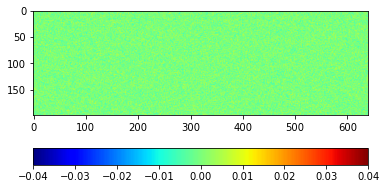

1


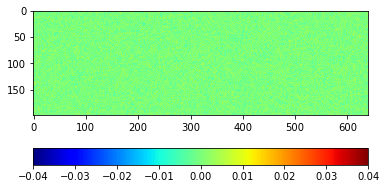

In [ ]:
#Visualization of the initial weight
path_w_ini = path_result+'w_ini/'
if os.path.exists(path_w_ini) == 0:
    os.mkdir(path_w_ini)

w_max = 0.04
w_min = - w_max

for i in range(w_ini.shape[1]):
    print(i)
    f = w_ini[:,i]
    f_im = f.reshape((round(w_ini.shape[0]/img_w), img_w))
    matplotlib.image.imsave(path_w_ini+'w_ini_n%d.png'%(i+1),
                            f_im, vmin=w_min, vmax=w_max, cmap='jet')
    
    fig = plt.figure()
    im = plt.imshow(f_im,'jet',vmin=w_min,vmax=w_max)
    fig.colorbar(im, orientation='horizontal')
    plt.show()

### 11.2.2) Trained weight

In [ ]:
#Check max and min values to ensure that colormap is suitably scaled
for i in range(5):
  print(np.max(w_train[i]))
  print(np.min(w_train[i]))

0.024530217
-0.023627143
0.059305087
-0.055336695
0.032430638
-0.029836038
0.025800882
-0.025680011
0.02757721
-0.02744795


In [ ]:
#Visualization of the weight
def view_weight(comb):
    k = comb - 1
    
    w_max = 0.02
    w_min = - w_max
    
    path_w_train = path_result+'w_train/'
    if os.path.exists(path_w_train) == 0:
        os.mkdir(path_w_train)

    print('Comb',comb)

    for i in range(w_train[k].shape[1]):
        print(i+1)
        path_w_comb = path_w_train+'w_comb'+str(comb)+'/'
    
        if os.path.exists(path_w_comb) == 0:
            os.mkdir(path_w_comb)
    
        f = w_train[k][:,i]
        f_im = f.reshape((round(f.shape[0]/img_w), img_w))
        matplotlib.image.imsave(
            path_w_comb+'w_comb'+str(comb)+'_n'+str(i+1)+'.png',
            f_im, cmap='jet', vmin=w_min, vmax=w_max)
    
        fig = plt.figure()
        im = plt.imshow(f_im,'jet',vmin=w_min,vmax=w_max)
        im.axes.get_xaxis().set_visible(False)
        im.axes.get_yaxis().set_visible(False)
        fig.colorbar(im, orientation='horizontal')
    
        plt.show()

Comb 1
1


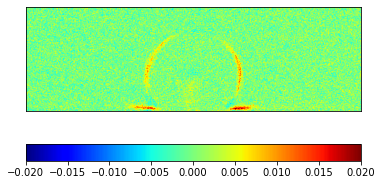

2


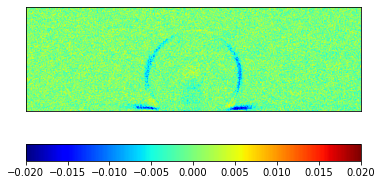

Comb 2
1


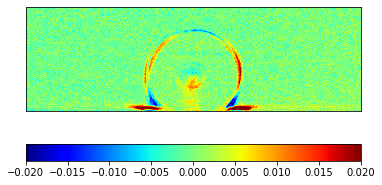

2


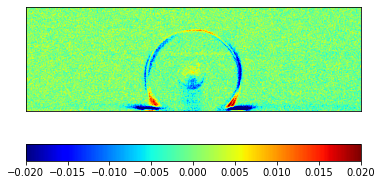

Comb 3
1


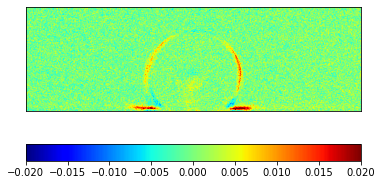

2


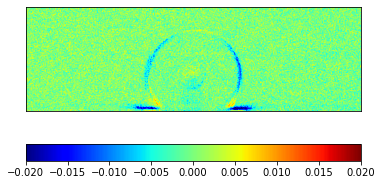

Comb 4
1


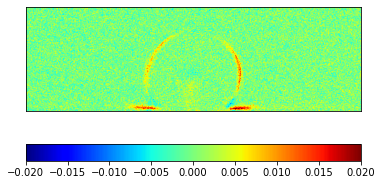

2


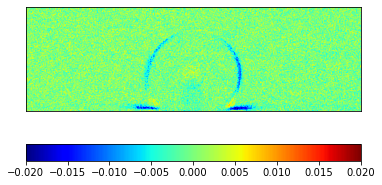

Comb 5
1


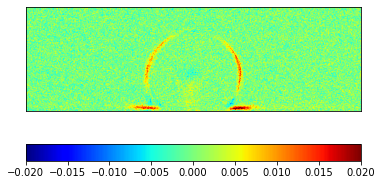

2


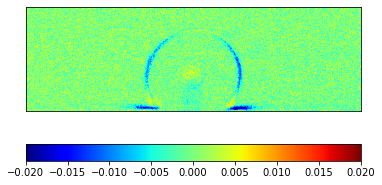

In [ ]:
for i in range(1,6):
    view_weight(i)

## 11.3) Bias $\mathbf{b}$

In [ ]:
path_bias = path_result + 'bias/'

if os.path.exists(path_bias) == 0:
    os.mkdir(path_bias)

bias_df = pd.DataFrame(columns=['Comb','b2_Spl.','b1_Nonspl.', 'min |qout|'])

for comb in range(1,6):
    k = comb - 1
    bias_df.loc[k] = [str(comb), '%.4f'%b_train[k][1], '%.4f'%b_train[k][0], 
                      '%.4f'%np.min(abs(q_out[k]))]

bias_df.loc[6] = ['Initial', '%.4f'%b_ini[1], '%.4f'%b_ini[0], 'N/A']

bias_df.to_csv(path_bias+'bias_combAll.csv', header=True, index=False)
bias_df

,Comb,b2_Spl.,b1_Nonspl.,min |qout|
0,1,0.0008,-0.0008,0.0317
1,2,0.0019,-0.0019,0.0756
2,3,0.0009,-0.0009,0.1531
3,4,0.0009,-0.0009,0.0658
4,5,0.0010,-0.0010,0.2026
6,Initial,0.0000,0.0000,N/A


## 11.4) $\mathbf{w}_i \circ \mathbf{s}_\mathrm{in}$

In [ ]:
#Visualization of Ws
for sf in range(2):
    for comb in range(1,6):
        k = comb - 1
    
        path_Ws = path_result+'Ws/'
        if os.path.exists(path_Ws) == 0:
            os.mkdir(path_Ws)
    
        path_Ws_sf = path_Ws+'n'+str(sf)+'/'
        if os.path.exists(path_Ws_sf) == 0:
            os.mkdir(path_Ws_sf)
    
        path_Ws_comb = path_Ws_sf+'Ws_comb'+str(comb)+'_n'+str(sf)+'/'
        if os.path.exists(path_Ws_comb) == 0:
            os.mkdir(path_Ws_comb)

        Ws_max = 0.02
        Ws_min = - Ws_max
    
        for i in range(x_test[k].shape[0]):
            f = x_test[k][i]*w_train[k][:,sf]
            f_im = f.reshape((round(f.shape[0]/img_w), img_w))
            f_im_name = \
            path_Ws_comb+'Ws_comb'+str(comb)+'_n'+str(sf)+'_'+str(id_test[k][i])+'.png'
            matplotlib.image.imsave(f_im_name, f_im, 
                                    vmin=Ws_min, vmax=Ws_max, cmap='jet')
        # print(i+1)

## 11.5) $q_{\mathrm{out}}$ and $y_{\mathrm{pred}}$

### 11.5.1) Define functions

In [ ]:
path_qout_ypred = path_result+'qout_ypred/'
path_qout_ypred_H = path_qout_ypred+'qout_ypred_H/'
path_qout_ypred_We = path_qout_ypred+'qout_ypred_We/'

if os.path.exists(path_qout_ypred) == 0:
    os.mkdir(path_qout_ypred)
if os.path.exists(path_qout_ypred_H) == 0:
    os.mkdir(path_qout_ypred_H)
if os.path.exists(path_qout_ypred_We) == 0:
    os.mkdir(path_qout_ypred_We)

In [ ]:
#Listing down the calculated values
def csv_qout_ypred(comb):
    k = comb - 1
    
    cqy = np.array(Ws[k])
    cqy[cqy==0] = np.nan
    
    # cqy1 = np.array(q_out[k])
    
    #Creating test_result file
    cqy_df = pd.DataFrame(H_test[k][:], columns = ['H'])
    cqy_df['id'] = id_test[k][:]
    cqy_df['U'] = np.round(U_test[k][:],2)
    cqy_df['Re'] = np.round(Re_test[k][:],2)
    cqy_df['We'] = np.round(We_test[k][:],2)

    if combine == 1:
        img_pix = int(img_h * img_w)
        for i in range(round(w_train[k].shape[0]/img_pix)):
            cqy_w = w_train[k][(img_pix*i):(img_pix*(i+1)),1]
            cqy_x = x_test[k][:,(img_pix*i):(img_pix*(i+1))]
            cqy_df['%.3f'%((i+1)*0.125)] = np.dot(cqy_x, cqy_w)
    
    for i in range(w_train[k].shape[1]):
        cqy_df['Ws%d'%(i+1)] = np.round(cqy[:,i],4)
    
    for i in range(w_train[k].shape[1]):
        cqy_df['qout%d'%(i+1)] = np.round(cqy[:,i],4)
    
    cqy_df['ypred_Nonspl.'] = np.round(y_pred[k][:,0],2)
    cqy_df['ypred_Spl'] = np.round(y_pred[k][:,1],2)
    cqy_df['prob.'] = np.round(prob[k][:,1],2)
    cqy_df['pred.'] = pred[k]
    cqy_df['ans.'] = y_test[k][:,1].astype(int)
    cqy_df['T/F'] = result_test_all[k]['T/F']
    
    path_cqy = path_qout_ypred+'csv/'
    if os.path.exists(path_cqy) == 0:
        os.mkdir(path_cqy)
        
    cqy_name = path_cqy+'csv_comb'+str(comb)+'.csv'
    cqy_df.to_csv(cqy_name, header=True, index=False)
    
    return cqy_df

In [ ]:
for i in range(5):
    if i == 0:
        a = min(q_out[i][:,1])
        b = max(q_out[i][:,1])
    else:
        if a > min(q_out[i][:,1]):
            a = min(q_out[i][:,1])
        if b < max(q_out[i][:,1]):
            b = max(q_out[i][:,1])

qout_min = math.floor(a/5) * 5
qout_max = math.ceil(b/5) * 5

In [ ]:
#Plotting q_out vs H
def plot_q_outvH_new(comb):
    k = comb - 1
    q_out_plt = q_out[k][:,1]
    H_plt = cqy_all[k]['H'].values/100

    TN = []
    TP = []
    FN = []
    FP = []
    H_TN = []
    H_TP = []
    H_FN = []
    H_FP = []

    TF_plt = cqy_all[k]['T/F']
    for i in range(len(cqy_all[k]['T/F'])):
        if TF_plt[i] == 'TN':
            H_TN.append(H_plt[i])
            TN.append(q_out_plt[i])
        elif TF_plt[i] == 'TP':
            H_TP.append(H_plt[i])
            TP.append(q_out_plt[i])
        elif TF_plt[i] == 'FN':
            H_FN.append(H_plt[i])
            FN.append(q_out_plt[i])
        elif TF_plt[i] == 'FP':
            H_FP.append(H_plt[i])
            FP.append(q_out_plt[i])
    
    lin_reg = LinearRegression()
    lin_reg.fit(H_plt.reshape(-1,1), q_out_plt)
    lin_reg.intercept_, lin_reg.coef_
    
    q_out_plt_predict = lin_reg.predict(H_plt.reshape(-1,1))
    MSE = mean_squared_error(q_out_plt,q_out_plt_predict)
    
    
    plt.plot(H_TP,TP, 'o', c='blue', label = 'Splash. (Correct)',
             fillstyle='none')
    plt.plot(H_TN,TN, 'o', c='green', label = 'Nonsplash. (Correct)',
             fillstyle='none')
    plt.plot([0,100],[0,0],ls='--',c='black', label='Classification Threshold')
    plt.plot(H_FN,FN, 'x', c='red', label = 'Splash. (Wrong)',fillstyle='none')
    plt.plot(H_FP,FP, 'x', c='orange', label = 'Nonsplash. (Wrong)',
             fillstyle='none')
    
    
    if np.max(q_out_plt) > np.max(q_out_plt_predict):
        q_outvH_max = np.max(q_out_plt)
    else:
        q_outvH_max = np.max(q_out_plt_predict)
    
    if np.min(q_out_plt) < np.min(q_out_plt_predict):
        q_outvH_min = np.min(q_out_plt)
    else:
        q_outvH_min = np.min(q_out_plt_predict)

    plt.fill_between([0.19,0.23], -100, 100, color='0.95',
                     label='Splashing Transition')
    
    plt.xlim([0,0.62])
    plt.ylim([qout_min,qout_max + 1])
    
    plt.xticks(np.arange(0,0.65, step = 0.10),fontsize=fs)
    plt.yticks(np.arange(qout_min,qout_max + 1, step = 5),fontsize=fs)
    plt.xlabel('$H~[\mathrm{m}]$', fontproperties=font)
    plt.ylabel('$q_{\mathrm{out,spl}}$ [-]', fontproperties=font)
    leg = plt.legend(loc=9, bbox_to_anchor=(0.5, 1.35), ncol=2, prop=font_leg, 
                     frameon=True)
    plt.grid(linestyle='solid', alpha=0.5)
    leg.get_frame().set_edgecolor('black')

In [ ]:
#Plotting Splash Probability vs H
def plot_prob_spl(comb):
    k = comb - 1
    prob_plt = prob[k][:,1]
    H_plt = cqy_all[k]['H'].values/100
    
    TN = []
    TP = []
    FN = []
    FP = []
    H_TN = []
    H_TP = []
    H_FN = []
    H_FP = []

    TF_plt = cqy_all[k]['T/F']
    for i in range(len(cqy_all[k]['T/F'])):
        if TF_plt[i] == 'TN':
            H_TN.append(H_plt[i])
            TN.append(prob_plt[i])
        elif TF_plt[i] == 'TP':
            H_TP.append(H_plt[i])
            TP.append(prob_plt[i])
        elif TF_plt[i] == 'FN':
            H_FN.append(H_plt[i])
            FN.append(prob_plt[i])
        elif TF_plt[i] == 'FP':
            H_FP.append(H_plt[i])
            FP.append(prob_plt[i])
    
    label_prob = 'Comb_' + str(comb)
    plt.plot(H_TP,TP, 'o', c='blue', label = 'Splash. (Correct)',
             fillstyle='none')
    plt.plot(H_TN,TN, 'o', c='green', label = 'Nonsplash. (Correct)',
             fillstyle='none')
    plt.plot([-10,65],[0.5,0.5],ls='--',c='black', 
             label='Classification Threshold')
    plt.plot(H_FN,FN, 'x', c='red', label = 'Splash. (Wrong)',
             fillstyle='none')
    plt.plot(H_FP,FP, 'x', c='orange', label = 'Nonsplash. (Wrong)',
             fillstyle='none')
    plt.fill_between([0.19,0.23], -2, 2, color='0.95', label='Splashing Transition')

    plt.xlim([0,0.62])
    plt.ylim([-0.05,1.05])
    
    plt.xticks(np.arange(0,0.65, step = 0.10),fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlabel('$H~[\mathrm{m}]$', fontproperties=font)
    plt.ylabel('$y_{\mathrm{pred,spl}}$ [-]', fontproperties=font)
    leg = plt.legend(loc=9, bbox_to_anchor=(0.5, 1.35), ncol=2, prop=font_leg, 
                     frameon=True)
    plt.grid(linestyle='solid', alpha=0.5)
    leg.get_frame().set_edgecolor('black')

In [ ]:
#Plotting Spread Probability vs H
def plot_prob_spr(comb):
    k = comb - 1
    prob_plt = prob[k][:,0]
    H_plt = cqy_all[k]['H'].values/100
    
    TN = []
    TP = []
    FN = []
    FP = []
    H_TN = []
    H_TP = []
    H_FN = []
    H_FP = []

    TF_plt = cqy_all[k]['T/F']
    for i in range(len(cqy_all[k]['T/F'])):
        if TF_plt[i] == 'TN':
            H_TN.append(H_plt[i])
            TN.append(prob_plt[i])
        elif TF_plt[i] == 'TP':
            H_TP.append(H_plt[i])
            TP.append(prob_plt[i])
        elif TF_plt[i] == 'FN':
            H_FN.append(H_plt[i])
            FN.append(prob_plt[i])
        elif TF_plt[i] == 'FP':
            H_FP.append(H_plt[i])
            FP.append(prob_plt[i])
    
    label_prob = 'Comb_' + str(comb)
    plt.plot(H_TP,TP, 'o', c='blue', label = 'Splash. (Correct)',fillstyle='none')
    plt.plot(H_TN,TN, 'o', c='green', label = 'Nonsplash. (Correct)',fillstyle='none')
    plt.plot([-10,65],[0.5,0.5],ls='--',c='black', label='Classification Threshold')
    plt.plot(H_FN,FN, 'x', c='red', label = 'Splash. (Wrong)',fillstyle='none')
    plt.plot(H_FP,FP, 'x', c='orange', label = 'Nonsplash. (Wrong)',fillstyle='none')
    plt.fill_between([19,23], -2, 2, color='0.95', label='Splashing Transition')
    
    plt.xlim([0,0.62])
    plt.ylim([-0.05,1.05])
    
    plt.xticks(np.arange(0,0.65, step = 0.1),fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlabel('$H~[\mathrm{m}]$', fontproperties=font)
    plt.ylabel('$y_{\mathrm{pred,nonspl}}$ [-]', fontproperties=font)
    leg = plt.legend(loc=9, bbox_to_anchor=(0.5, 1.35), ncol=2, prop=font_leg, 
                     frameon=True)
    plt.grid(linestyle='solid', alpha=0.5)
    leg.get_frame().set_edgecolor('black')

In [ ]:
#Plotting q_out vs We
def plot_q_outvWe_new(comb):
    k = comb - 1
    q_out_plt = q_out[k][:,1]
    H_plt = cqy_all[k]['We'].values

    TN = []
    TP = []
    FN = []
    FP = []
    H_TN = []
    H_TP = []
    H_FN = []
    H_FP = []

    TF_plt = cqy_all[k]['T/F']
    for i in range(len(cqy_all[k]['T/F'])):
        if TF_plt[i] == 'TN':
            H_TN.append(H_plt[i])
            TN.append(q_out_plt[i])
        elif TF_plt[i] == 'TP':
            H_TP.append(H_plt[i])
            TP.append(q_out_plt[i])
        elif TF_plt[i] == 'FN':
            H_FN.append(H_plt[i])
            FN.append(q_out_plt[i])
        elif TF_plt[i] == 'FP':
            H_FP.append(H_plt[i])
            FP.append(q_out_plt[i])
    
    plt.plot(H_TP,TP, 'o', c='blue', label = 'Splash. (Correct)',
             fillstyle='none')
    plt.plot(H_TN,TN, 'o', c='green', label = 'Nonsplash. (Correct)',
             fillstyle='none')
    plt.plot([-100,2000],[0,0],ls='--',c='black', label='Classification Threshold')
    plt.plot(H_FN,FN, 'x', c='red', label = 'Splash. (Wrong)',fillstyle='none')
    plt.plot(H_FP,FP, 'x', c='orange', label = 'Nonsplash. (Wrong)',
             fillstyle='none')
    
    lin_reg = LinearRegression()
    lin_reg.fit(H_plt.reshape(-1,1), q_out_plt)
    lin_reg.intercept_, lin_reg.coef_
    
    q_out_plt_predict = lin_reg.predict(H_plt.reshape(-1,1))
    MSE = mean_squared_error(q_out_plt,q_out_plt_predict)
    
    if np.max(q_out_plt) > np.max(q_out_plt_predict):
        q_outvH_max = np.max(q_out_plt)
    else:
        q_outvH_max = np.max(q_out_plt_predict)
    
    if np.min(q_out_plt) < np.min(q_out_plt_predict):
        q_outvH_min = np.min(q_out_plt)
    else:
        q_outvH_min = np.min(q_out_plt_predict)

    plt.fill_between([348,386], -100, 100, color='0.95',label='Splashing Transition')#id = 90, 107
    
    plt.xlim([-20,1020])
    plt.ylim([qout_min,qout_max + 1])
    
    plt.xticks(np.arange(0,1001, step = 200),fontsize=fs)
    plt.yticks(np.arange(qout_min,qout_max + 1, step = 5),fontsize=fs)
    plt.xlabel('$We~[-]$', fontproperties=font)
    plt.ylabel('$q_{\mathrm{out,spl}}$ [-]', fontproperties=font)
    leg = plt.legend(loc=9, bbox_to_anchor=(0.5, 1.35), ncol=2, prop=font_leg, 
                     frameon=True)
    plt.grid(linestyle='solid', alpha=0.5)
    leg.get_frame().set_edgecolor('black')

In [ ]:
#Plotting Splash Probability vs We
def plot_prob_spl_We(comb):
    k = comb - 1
    prob_plt = prob[k][:,1]
    H_plt = cqy_all[k]['We'].values
    
    TN = []
    TP = []
    FN = []
    FP = []
    H_TN = []
    H_TP = []
    H_FN = []
    H_FP = []

    TF_plt = cqy_all[k]['T/F']
    for i in range(len(cqy_all[k]['T/F'])):
        if TF_plt[i] == 'TN':
            H_TN.append(H_plt[i])
            TN.append(prob_plt[i])
        elif TF_plt[i] == 'TP':
            H_TP.append(H_plt[i])
            TP.append(prob_plt[i])
        elif TF_plt[i] == 'FN':
            H_FN.append(H_plt[i])
            FN.append(prob_plt[i])
        elif TF_plt[i] == 'FP':
            H_FP.append(H_plt[i])
            FP.append(prob_plt[i])
    
    label_prob = 'Comb_' + str(comb)
    plt.plot(H_TP,TP, 'o', c='blue', label = 'Splash. (Correct)',
             fillstyle='none')
    plt.plot(H_TN,TN, 'o', c='green', label = 'Nonsplash. (Correct)',
             fillstyle='none')
    plt.plot([-100,2000],[0.5,0.5],ls='--',c='black', 
             label='Classification Threshold')
    plt.plot(H_FN,FN, 'x', c='red', label = 'Splash. (Wrong)',
             fillstyle='none')
    plt.plot(H_FP,FP, 'x', c='orange', label = 'Nonsplash. (Wrong)',
             fillstyle='none')
    plt.fill_between([348,386], -100, 100, color='0.95',label='Splashing Transition')#id = 90, 107

    plt.xlim([-20,1020])
    plt.ylim([-0.05,1.05])
    
    plt.xticks(np.arange(0,1001, step = 200),fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlabel('$We~[-]$', fontproperties=font)
    plt.ylabel('$y_{\mathrm{pred,spl}}$ [-]', fontproperties=font)
    leg = plt.legend(loc=9, bbox_to_anchor=(0.5, 1.35), ncol=2, prop=font_leg, 
                     frameon=True)
    plt.grid(linestyle='solid', alpha=0.5)
    leg.get_frame().set_edgecolor('black')

In [ ]:
#Plotting Spread Probability vs We
def plot_prob_spr_We(comb):
    k = comb - 1
    prob_plt = prob[k][:,0]
    H_plt = cqy_all[k]['We'].values
    
    TN = []
    TP = []
    FN = []
    FP = []
    H_TN = []
    H_TP = []
    H_FN = []
    H_FP = []

    TF_plt = cqy_all[k]['T/F']
    for i in range(len(cqy_all[k]['T/F'])):
        if TF_plt[i] == 'TN':
            H_TN.append(H_plt[i])
            TN.append(prob_plt[i])
        elif TF_plt[i] == 'TP':
            H_TP.append(H_plt[i])
            TP.append(prob_plt[i])
        elif TF_plt[i] == 'FN':
            H_FN.append(H_plt[i])
            FN.append(prob_plt[i])
        elif TF_plt[i] == 'FP':
            H_FP.append(H_plt[i])
            FP.append(prob_plt[i])
    
    label_prob = 'Comb_' + str(comb)
    plt.plot(H_TP,TP, 'o', c='blue', label = 'Splash. (Correct)',fillstyle='none')
    plt.plot(H_TN,TN, 'o', c='green', label = 'Nonsplash. (Correct)',fillstyle='none')
    plt.plot([-5,1000],[0.5,0.5],ls='--',c='black', label='Classification Threshold')
    plt.plot(H_FN,FN, 'x', c='red', label = 'Splash. (Wrong)',fillstyle='none')
    plt.plot(H_FP,FP, 'x', c='orange', label = 'Nonsplash. (Wrong)',fillstyle='none')
    plt.fill_between([348,386], -2, 2, color='0.95', label='Splashing Transition')#id = 90, 107
    
    plt.xlim([-20,1020])
    plt.ylim([-0.05,1.05])
    
    plt.xticks(np.arange(0,1001, step = 200),fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlabel('$We~[-]$', fontproperties=font)
    plt.ylabel('$y_{\mathrm{pred,nonspl}}$ [-]', fontproperties=font)
    leg = plt.legend(loc=9, bbox_to_anchor=(0.5, 1.35), ncol=2, prop=font_leg, 
                     frameon=True)
    plt.grid(linestyle='solid', alpha=0.5)
    leg.get_frame().set_edgecolor('black')

### 11.5.2) CSV

In [ ]:
#Combine all csv files
cqy_all = []

for i in range(1,6):
    cqy_all.append(csv_qout_ypred(i))

In [ ]:
cqy_all[1]

,H,id,U,Re,We,Ws1,Ws2,qout1,qout2,ypred_Nonspl.,ypred_Spl,prob.,pred.,ans.,T/F
0,4,3,0.83,1602.38,65.14,5.1616,-5.1918,5.1616,-5.1918,0.99,0.01,0.01,0,0,TN
1,4,4,0.82,1577.37,63.25,6.6624,-6.7107,6.6624,-6.7107,1.00,0.00,0.00,0,0,TN
2,4,13,0.83,1635.62,66.67,2.9015,-2.9033,2.9015,-2.9033,0.95,0.05,0.05,0,0,TN
3,4,14,0.84,1589.89,64.98,4.9143,-4.9833,4.9143,-4.9833,0.99,0.01,0.01,0,0,TN
4,8,23,1.22,2370.28,141.38,1.4298,-1.3779,1.4298,-1.3779,0.81,0.20,0.20,0,0,TN
5,8,24,1.25,2293.52,140.36,3.1540,-3.1934,3.1540,-3.1934,0.96,0.04,0.04,0,0,TN
6,8,33,1.25,2440.77,148.52,2.0355,-2.0166,2.0355,-2.0166,0.88,0.12,0.12,0,0,TN
7,8,34,1.25,2327.24,141.70,3.3244,-3.3397,3.3244,-3.3397,0.97,0.03,0.03,0,0,TN
8,12,43,1.51,2825.81,208.19,4.2003,-4.2786,4.2003,-4.2786,0.99,0.01,0.01,0,0,TN
9,12,44,1.50,2796.50,205.32,5.8744,-5.8869,5.8744,-5.8869,1.00,0.00,0.00,0,0,TN


### 11.5.3) Plots against Impact Height $H$

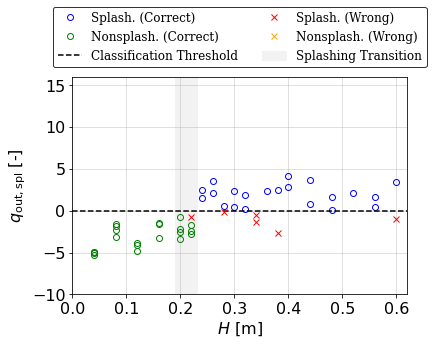

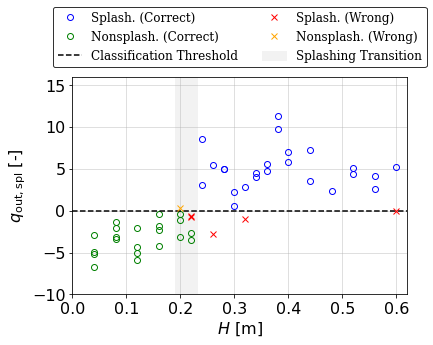

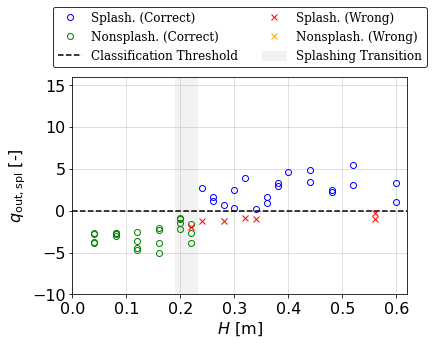

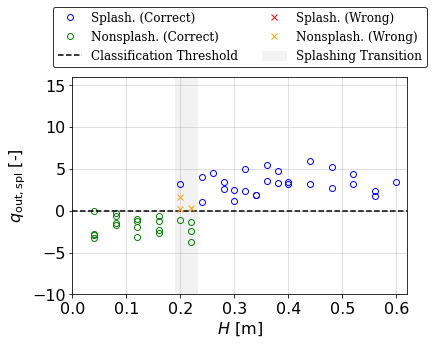

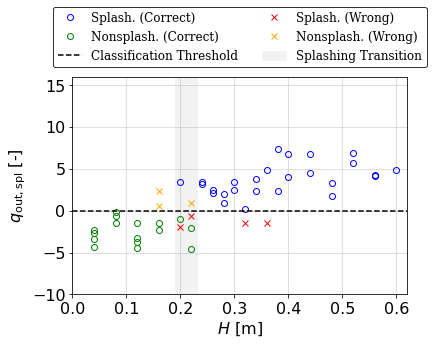

In [ ]:
#Plot q2 vs H for all combinations
path_qout_H = path_qout_ypred_H + 'qout/'

if os.path.exists(path_qout_H) == 0:
  os.mkdir(path_qout_H)

for i in range(1,6):
  plot_q_outvH_new(i)
  plt.savefig(path_qout_H+'qout_H_Comb%d.png'%i, dpi=300, bbox_inches='tight')
  plt.show()

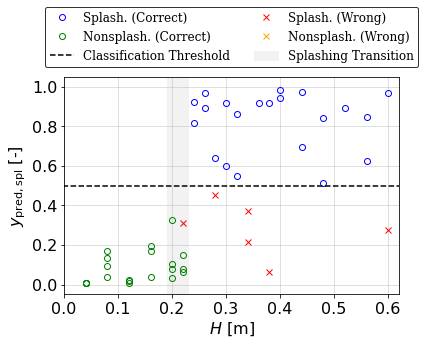

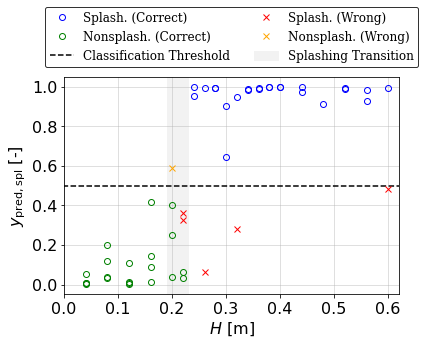

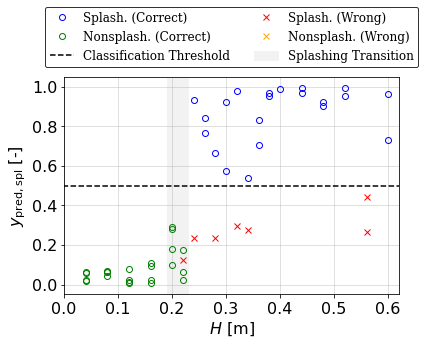

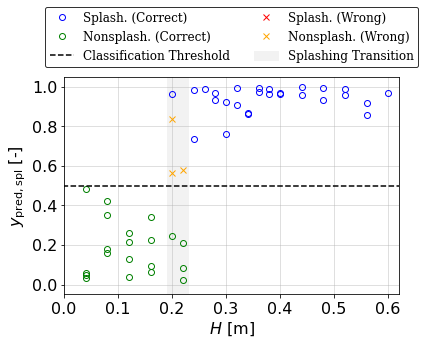

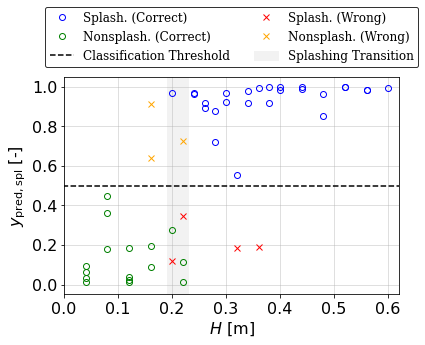

In [ ]:
#Plot splash probability vs H for all combinations
path_ypred_spl_H = path_qout_ypred_H + 'ypred_spl_H/'

if os.path.exists(path_ypred_spl_H) == 0:
  os.mkdir(path_ypred_spl_H)

for i in range(1,6):
  plot_prob_spl(i)
  plt.savefig(path_ypred_spl_H+'ypred_spl_H_Comb%d.png'%i, dpi=300, bbox_inches='tight')
  plt.show()

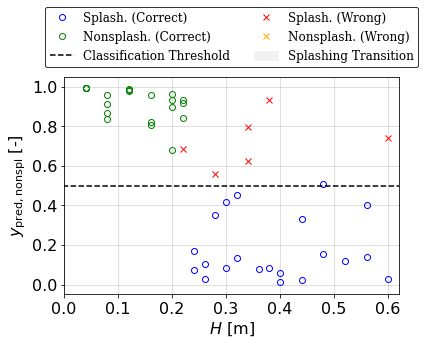

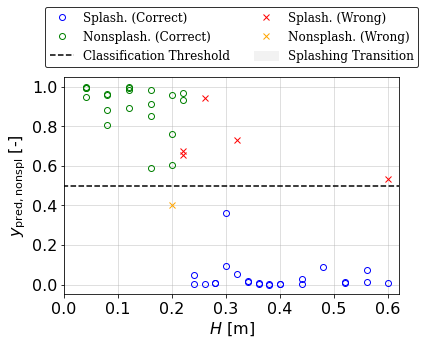

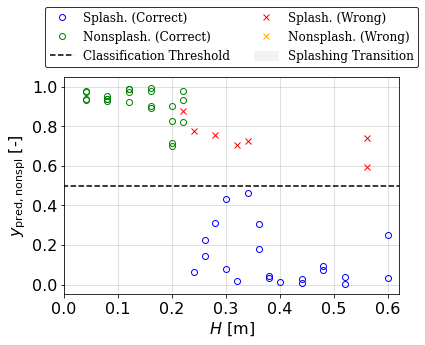

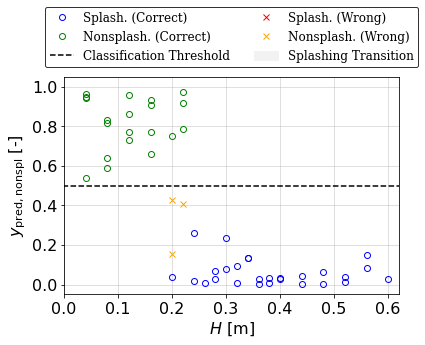

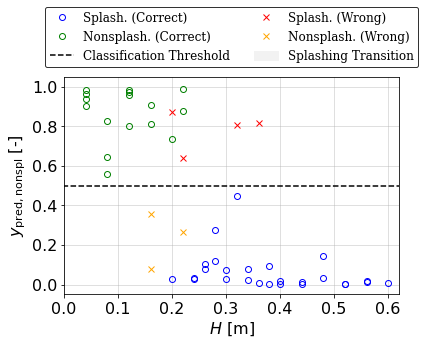

In [ ]:
#Plot splash probability vs H for all combinations
path_ypred_nonspl_H = path_qout_ypred_H + 'ypred_nonspl_H/'

if os.path.exists(path_ypred_nonspl_H) == 0:
    os.mkdir(path_ypred_nonspl_H)

for i in range(1,6):
    plot_prob_spr(i)
    plt.savefig(path_ypred_nonspl_H+'ypred_nonspl_H_Comb%d.png'%i, 
                dpi=300, bbox_inches='tight')
    plt.show()

### 11.5.3) Plots against Weber Number $We$

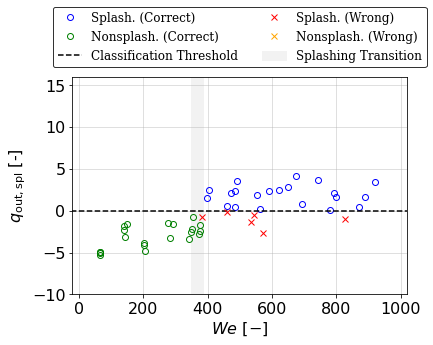

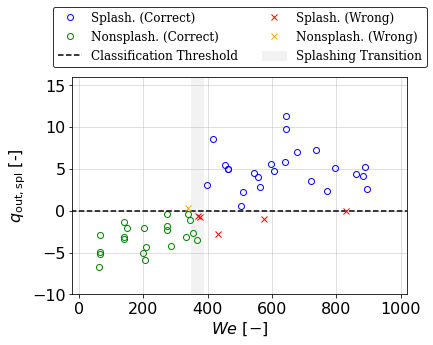

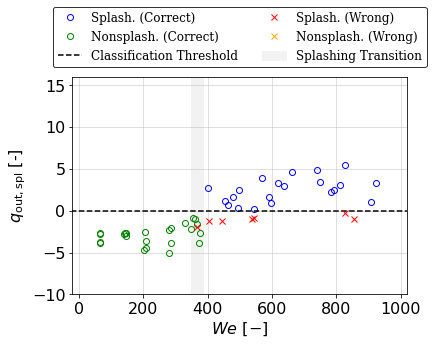

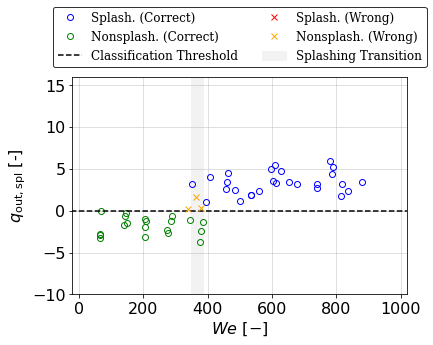

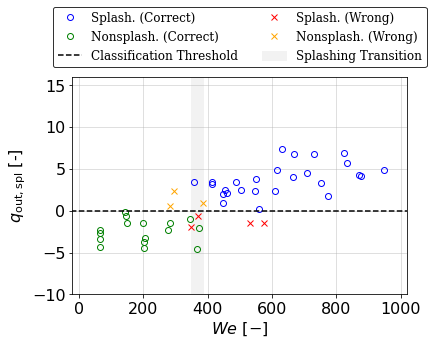

In [ ]:
#Plot q2 vs We for all combinations
path_qout_We = path_qout_ypred_We + 'qout_We/'

if os.path.exists(path_qout_We) == 0:
  os.mkdir(path_qout_We)

for i in range(1,6):
  plot_q_outvWe_new(i)
  plt.savefig(path_qout_We+'qout_We_Comb%d.png'%i, dpi=300, bbox_inches='tight')
  plt.show()

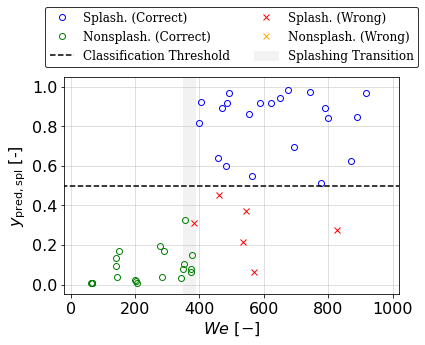

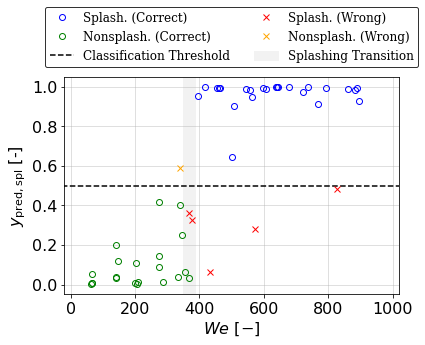

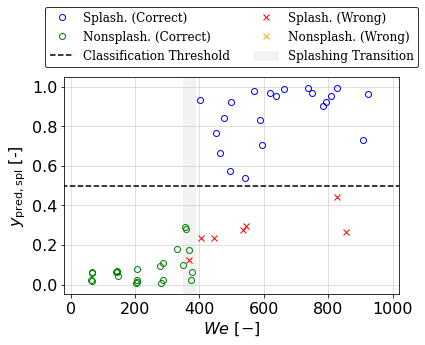

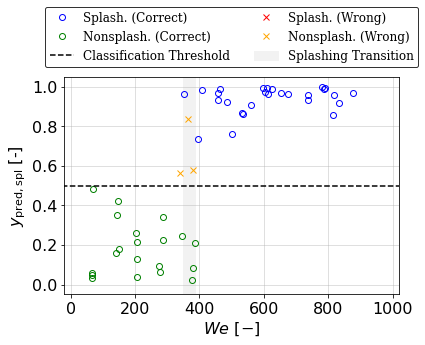

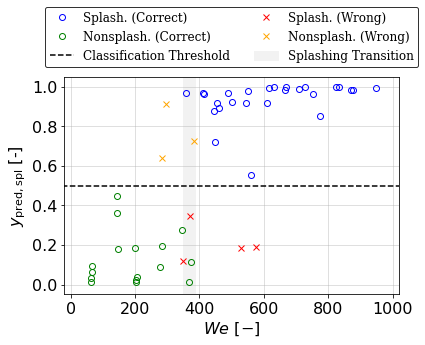

In [ ]:
#Plot splash probability vs H for all combinations
path_ypred_spl_We = path_qout_ypred_We + 'ypred_spl_We/'

if os.path.exists(path_ypred_spl_We) == 0:
  os.mkdir(path_ypred_spl_We)

for i in range(1,6):
  plot_prob_spl_We(i)
  plt.savefig(path_ypred_spl_We+'ypred_spl_We_Comb%d.png'%i, dpi=300, bbox_inches='tight')
  plt.show()

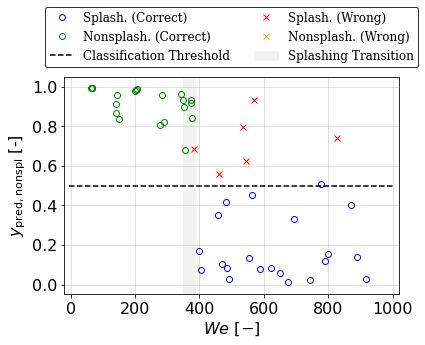

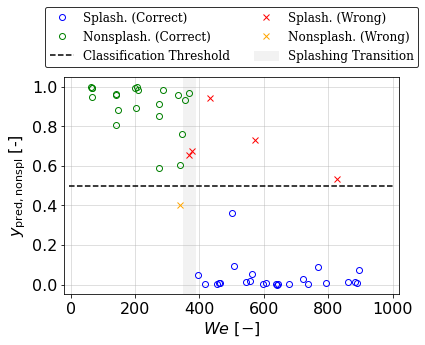

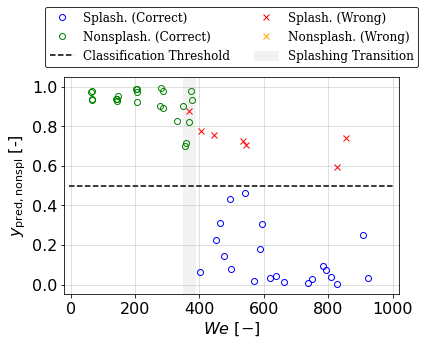

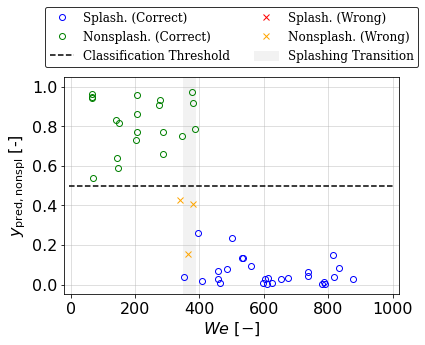

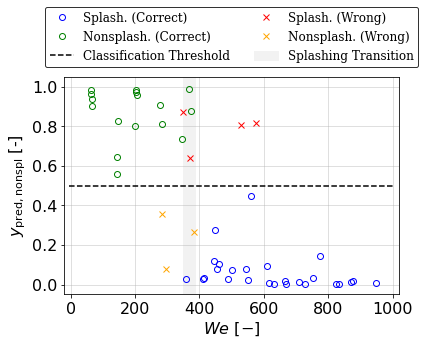

In [ ]:
#Plot splash probability vs H for all combinations
path_ypred_nonspl_We = path_qout_ypred_We + 'ypred_nonspl_We/'

if os.path.exists(path_ypred_nonspl_We) == 0:
    os.mkdir(path_ypred_nonspl_We)

for i in range(1,6):
    plot_prob_spr_We(i)
    plt.savefig(path_ypred_nonspl_We+'ypred_nonspl_We_Comb%d.png'%i, 
                dpi=300, bbox_inches='tight')
    plt.show()

### 11.5.4) Plots of $q_{\mathrm{out,spl},\tau}$ by parts 
(Only for image-sequence classification)

In [ ]:
for i in range(5):
    print('Comb: ', i+1)
    print(np.max(q_out[i][:,1]))
    print(np.min(q_out[i][:,1]))
    
    q_part = []
    for j in range(1,8):
        q_part.append(cqy_all[i]['%.3f'%(j*0.125)].values)
    
    q_part = np.array(q_part)
    print(np.max(q_part))
    print(np.min(q_part))

In [ ]:
#Plotting q_out vs H
#variables: H_plt, q_out_plt
def plot_Q_byPartvq_out(comb):
    k = comb - 1
    q_out_plt = q_out[k][:,1]
    
    x_min = -20
    x_max = 32
    x_step = 10
    
    y_min = -10
    y_max = 11
    y_step = 5
    
    colorIter = iter(('tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive'))
    for i in range(round(x_test[0][0].shape[0]/img_pix)):
        sameColor = next(colorIter)
        Q_plt = cqy_all[k]['%.3f'%((i+1)*0.125)].values
        plt.plot(q_out_plt,Q_plt, 'o', label = r'$\tau$ = %.3f'%((i+1)*0.125), color=sameColor, fillstyle='none')
        m_Q,b_Q = np.polyfit(q_out_plt,Q_plt, 1)
        xseq = np.linspace(min(q_out_plt),max(q_out_plt),num=100)
        plt.plot(xseq,m_Q*xseq+b_Q, ':', color=sameColor)
    
    plt.plot([0,0],[-100,100],ls='--',c='gray', label='$q_{\mathrm{out,spl}}=0$')
    
    plt.xlim([x_min-2,x_max])
    plt.ylim([y_min-1,y_max])
    
    plt.xticks(np.arange(x_min,x_max,step=x_step),fontsize=fs)
    # plt.xticks(fontsize=fs)
    plt.yticks(np.arange(y_min,y_max,step=y_step),fontsize=fs)
    # plt.yticks(fontsize=fs)
    # plt.xlabel(r'$H^{1/2} (\mathrm{cm}^{1/2})$', fontproperties=font)
    plt.xlabel(r'$q_{\mathrm{out,spl}}$ [-]', fontproperties=font)
    plt.ylabel(r'$q_{\mathrm{out,spl},\tau}$ [-]', fontproperties=font)
    # plt.title(label_q_out)#('Splash Intensity, q_out')
    leg = plt.legend(loc=9, bbox_to_anchor=(0.5, 1.35), ncol=3, prop=font_leg, frameon=True)
    plt.grid(linestyle='solid', alpha=0.5)
    leg.get_frame().set_edgecolor('black')

In [ ]:
path_q_outByPart = path_result + 'q_outByPart/'
if os.path.exists(path_q_outByPart) == 0:
    os.mkdir(path_q_outByPart)
    
for i in range(1,6):
    plot_Q_byPartvq_out(i)
    plt.savefig(path_q_outByPart+'q_outByPart_Comb%d.png'%i, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
path_qGrad = path_result + 'qGrad/'
if os.path.exists(path_qGrad) == 0:
    os.mkdir(path_qGrad)

for comb in range(1,6):
    k = comb - 1
    q_out_plt = q_out[k][:,1]
    Q_grad_x = np.arange(0.125,1,0.125)
    Q_grad = []
    
    x_min = 0
    x_max = 1.05
    x_step = 0.25
    
    y_min = 0
    y_max = 0.32
    y_step = 0.05
    
    for i in range(round(x_test[0][0].shape[0]/img_pix)):
        Q_plt = cqy_all[k]['%.3f'%((i+1)*0.125)].values
        m_Q,b_Q = np.polyfit(q_out_plt,Q_plt, 1)
        Q_grad.append(m_Q)
    
    plt.plot(Q_grad_x, Q_grad, 'o', label = 'Comb. %d'%(k+1), fillstyle='none')
    
    plt.xlim([x_min-0.05,x_max])
    plt.ylim([y_min-0.02,y_max])
    
    plt.xticks(np.arange(x_min,x_max,step=x_step),fontsize=fs)
    plt.yticks(np.arange(y_min,y_max,step=y_step),fontsize=fs)
    plt.xlabel(r'$\tau$ [-]', fontproperties=font)
    plt.ylabel(r'$\beta$ [-]', fontproperties=font)
    # plt.title(label_q_out)#('Splash Intensity, q_out')
    leg = plt.legend(loc=9, bbox_to_anchor=(0.5, 1.25), ncol=3, prop=font_leg, 
                     frameon=True)
    plt.grid(linestyle='solid', alpha=0.5)
    leg.get_frame().set_edgecolor('black')

plt.savefig(path_qGrad+'qGrad_All.png', dpi=300, bbox_inches='tight')
plt.show()